# Effect of voltage history on spike timing in DRN SOM neurons

Shown in fig. 1S2.

In [1]:
from common import colors, sbarlw, insetlw

In [2]:
import os
os.chdir(os.path.join('..', '..', '..'))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import pandas as pd
from ezephys.rectools import ABFLoader
from ezephys.pltools import hide_border
from ezephys import pltools

from grr.Spiketrain import getSpikeLatency
from grr.Tools import timeToIndex, dashedBorder

In [4]:
DATA_PATH = os.path.join('data', 'raw', 'GABA', 'spk_time')
IMG_PATH = None
NOTEBOOK_PATH = os.path.join('figs', 'scripts')

plt.style.use(os.path.join(NOTEBOOK_PATH, 'publication_figure_style.dms'))

In [5]:
inventory = pd.read_csv(os.path.join(DATA_PATH, 'index.csv'))
inventory['cumcount'] = inventory.groupby('cell_id').cumcount()
fnames = inventory.pivot(
    'cell_id', 'cumcount', values='recording'
).values.tolist()
fnames = [[f for f in fs if f is not None] for fs in fnames]  # Remove `None`s

cellnames = inventory.pivot(
    'cell_id', 'cumcount', values='recording'
).index.tolist()

# Manually reject recordings.
rejects = ['18711002.abf']

# Load cells into nested list: `cells[cell_number][recording_numer]`
loader = ABFLoader()
experiments = []
for i in range(len(fnames)):
    experiments.append(
        loader.load(
            [os.path.join(DATA_PATH, fname) for fname in fnames[i] if fname not in rejects]
        )
    )

In [6]:
latency_extraction_params = {
    'V_pre_slice': slice(timeToIndex(2495.0, 0.1)[0], timeToIndex(2595.0, 0.1)[0]),
    'I_step_slice': slice(timeToIndex(2647.0, 0.1)[0], timeToIndex(2747.0, 0.1)[0]),
    'baseline_slice': slice(timeToIndex(0, 0.1)[0], timeToIndex(100., 0.1)[0]),
    'step_start_time': 2647.0,
}
latency_data = {'latency': [], 'voltage': [], 'current': []}
for expt in experiments:
    single_expt_latency = {'latency': [], 'voltage': [], 'current': []}
    for rec in expt:
        single_expt_latency['current'].append(
            (
                np.mean(rec[1, latency_extraction_params['I_step_slice'], :])
                - np.mean(rec[1, latency_extraction_params['baseline_slice'], :])
            )
        )
        for sweep in range(rec.shape[2]):
            single_expt_latency['latency'].append(
                getSpikeLatency(
                    rec[0, :, sweep],
                    latency_extraction_params['step_start_time'],
                )
            )
            single_expt_latency['voltage'].append(
                np.mean(
                    rec[0, latency_extraction_params['V_pre_slice'], sweep]
                )
            )
    for key in latency_data:
        latency_data[key].append(np.array(single_expt_latency[key]))

del single_expt_latency

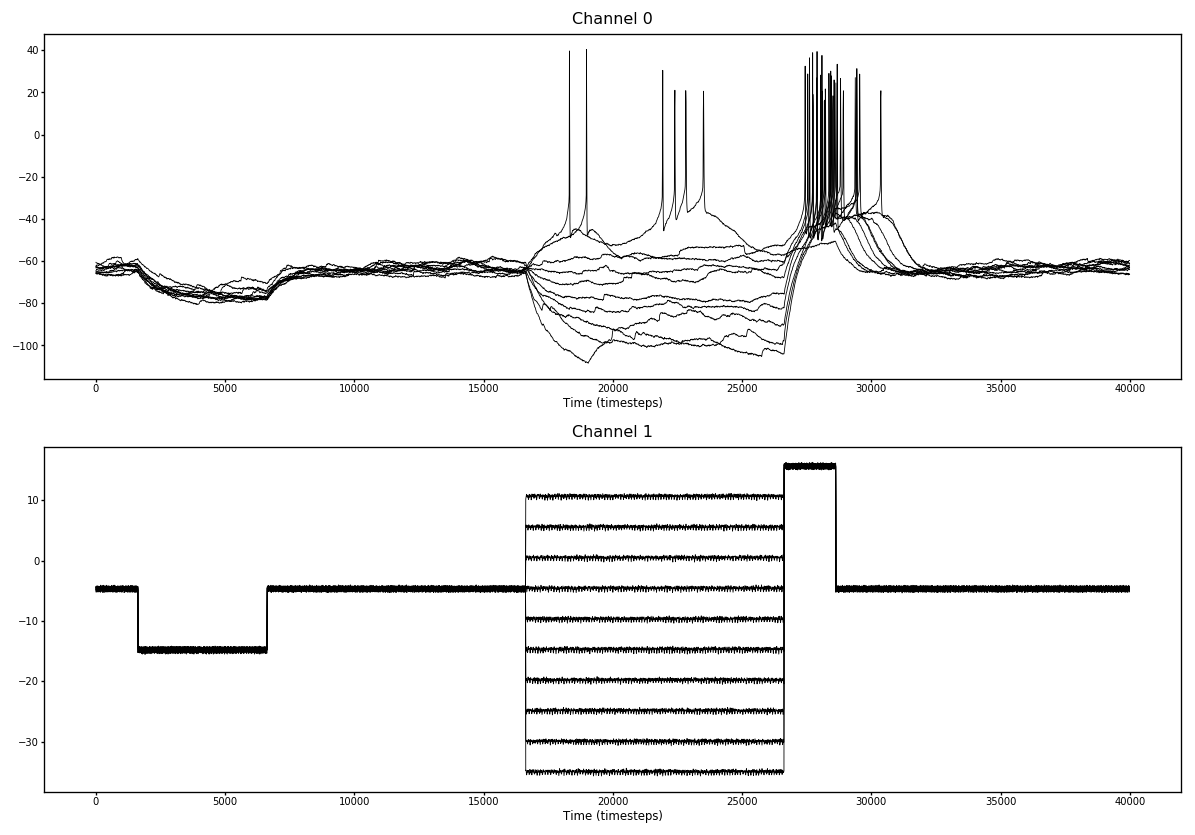

In [7]:
experiments[0][0].plot()

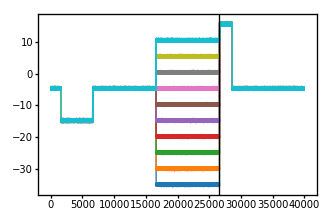

In [8]:
plt.plot(experiments[0][0][1, ...])
plt.axvline(latency_extraction_params['step_start_time'] / experiments[0][0].dt)

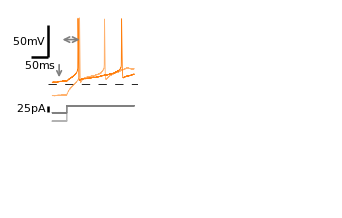

In [9]:
sample_rec = experiments[2][0]
sweeps = {
    'lo': 2,
    'hi': 8
}

spec = gs.GridSpec(2, 1, height_ratios = [1, 0.2], hspace = 0.1)

plt.figure(figsize = (1, 1))

trace_time_slice = slice(timeToIndex(2620.0, 0.1)[0], timeToIndex(2860.0, 0.1)[0])
t_vec = np.arange(0, 240, 0.1)
V_ax = plt.subplot(spec[0, 0])
#plt.title(' 5HT neuron', loc = 'left')
plt.axhline(-60, color = 'k', ls = '--', lw = 0.5, dashes = (10, 10))
plt.annotate('$-60$mV', (300, -65), ha = 'right', va = 'top', size=7)
plt.annotate('', (20, 9), (90, 9), arrowprops = {'arrowstyle': '<->'})
#plt.text(150, 14, 'Latency', ha = 'center', size=7)

I_ax = plt.subplot(spec[1, 0])
plt.annotate('$30$pA', (300, 28), ha = 'right', va = 'top', size=7)


V_ax.plot(
    t_vec, sample_rec[0, trace_time_slice, sweeps['lo']],
    '-', color=colors['som'], lw=0.5, alpha = 0.6
)
V_ax.plot(
    t_vec, sample_rec[0, trace_time_slice, sweeps['hi']],
    '-', color=colors['som'], lw=0.5
)
I_ax.plot(
    t_vec, sample_rec[1, trace_time_slice, sweeps['lo']], 
    color=colors['input'], alpha = 0.6
)
I_ax.plot(
    t_vec, sample_rec[1, trace_time_slice, sweeps['hi']], 
    color=colors['input']
)

pltools.add_scalebar(
    y_units = 'mV', x_units = 'ms', anchor = (0, 0.5),
    x_size = 50,
    bar_space = 0, ax = V_ax,
    linewidth=sbarlw
)
pltools.add_scalebar(
    y_units='pA', anchor=(0, 0.5),
    omit_x=True,
    ax=I_ax,
    linewidth=sbarlw
)
V_ax.annotate(
    '',
    (20, -55),
    xytext=(20, -25),
    xycoords='data',
    textcoords='data',
    arrowprops={'arrowstyle': '->'},
    ha='center',
    size=7
)

plt.subplots_adjust(left=0.15, bottom=0.05, top=0.95, right=0.90)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'som_latency_demo_trace.png'))
    plt.savefig(os.path.join(IMG_PATH, 'som_latency_demo_trace.svg'))

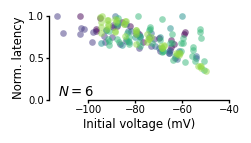

In [10]:

plt.figure(figsize=(2, 1))

plt.subplot(111)
for i, (latencies, voltages) in enumerate(zip(latency_data['latency'], latency_data['voltage'])):
    plt.plot(
        voltages, 
        latencies / np.nanmax(latencies), 
        'o',
        alpha=0.5,
        color=plt.cm.viridis(float(i)/len(latency_data['latency'])),
        markeredgecolor='none',
        markersize=4,
        clip_on=False
    )
plt.text(
    0.05, 
    0.05, 
    '$N = {}$'.format(len(latency_data['latency'])), 
    transform=plt.gca().transAxes
)
plt.ylim(0, 1)
plt.xticks(np.arange(-100, -20, 20))
plt.yticks([0, 0.5, 1])
plt.xlabel('Initial voltage (mV)')
plt.ylabel('Norm. latency')
hide_border('tr', trim=True)

plt.subplots_adjust(bottom=0.25, left=0.2, top=0.95, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'gaba_latency_steps.png'))
    plt.savefig(os.path.join(IMG_PATH, 'gaba_latency_steps.svg'))

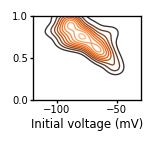

In [11]:
plt.figure(figsize=(1.2, 1))

plt.subplot(111)
v_arr = np.concatenate(latency_data['voltage'])
lat_arr = np.concatenate([x / np.nanmax(x) for x in latency_data['latency']])
sns.kdeplot(
    v_arr[~np.isnan(lat_arr)],
    lat_arr[~np.isnan(lat_arr)],
    cmap='Oranges_d'
)
plt.ylim(0, 1)
plt.xlim(-120, -30)
plt.yticks([0, 0.5, 1])
plt.ylabel('')
plt.xlabel('Initial voltage (mV)')

plt.subplots_adjust(bottom=0.25, left=0.2, top=0.95, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'gaba_latency_steps_kde.png'))
    plt.savefig(os.path.join(IMG_PATH, 'gaba_latency_steps_kde.svg'))

# Paired recordings in a burst neuron

In [12]:
def load_all_recs_in_dir(loader, dir_):
    recs = loader.load(
        [
            os.path.join(dir_, fname) for fname in os.listdir(dir_) 
            if fname.upper().endswith('.ABF')
        ]
    )
    return recs

In [13]:
loader = ABFLoader()
bursty_recs = load_all_recs_in_dir(
    ABFLoader(), 
    os.path.join('data', 'raw', 'GABA', 'DRN398_firing_vsteps')
)
non_bursty_recs = load_all_recs_in_dir(
    ABFLoader(), 
    os.path.join('data', 'raw', 'GABA', 'DRN393_firing_vsteps')
)

Recording 0


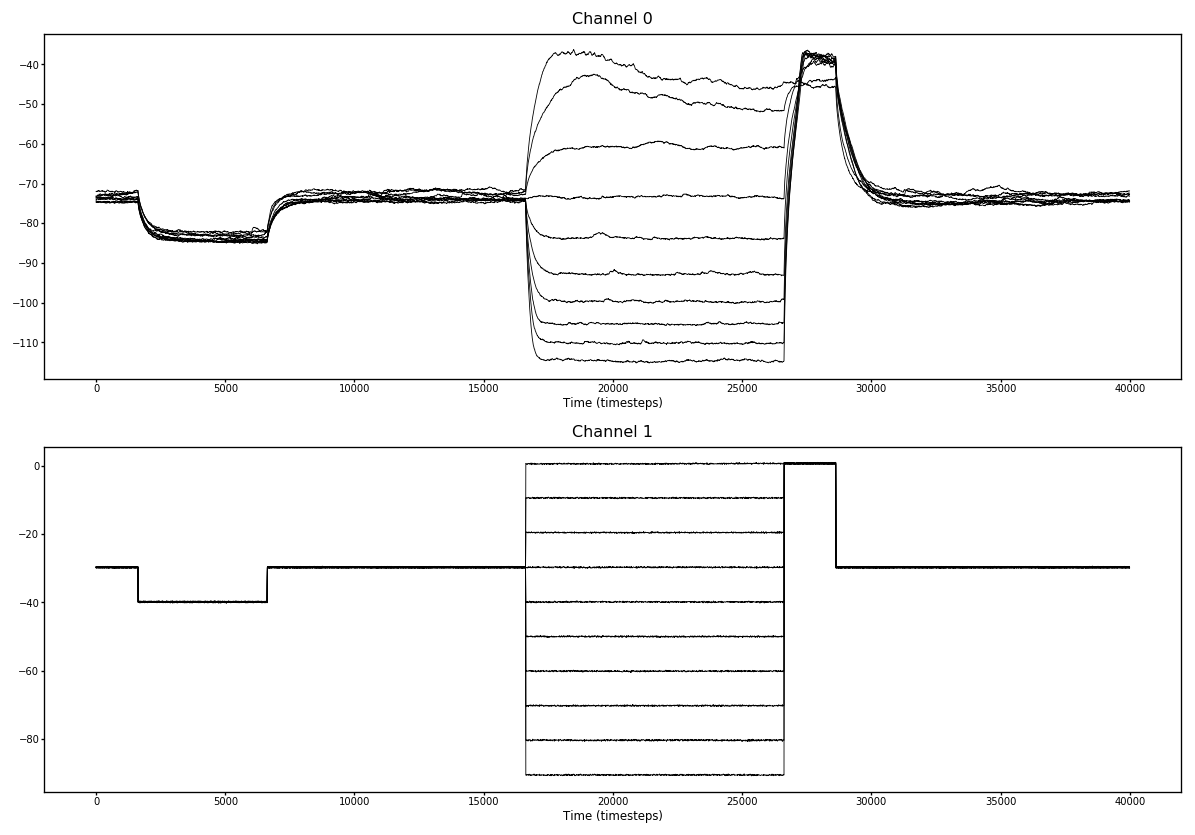

Recording 1


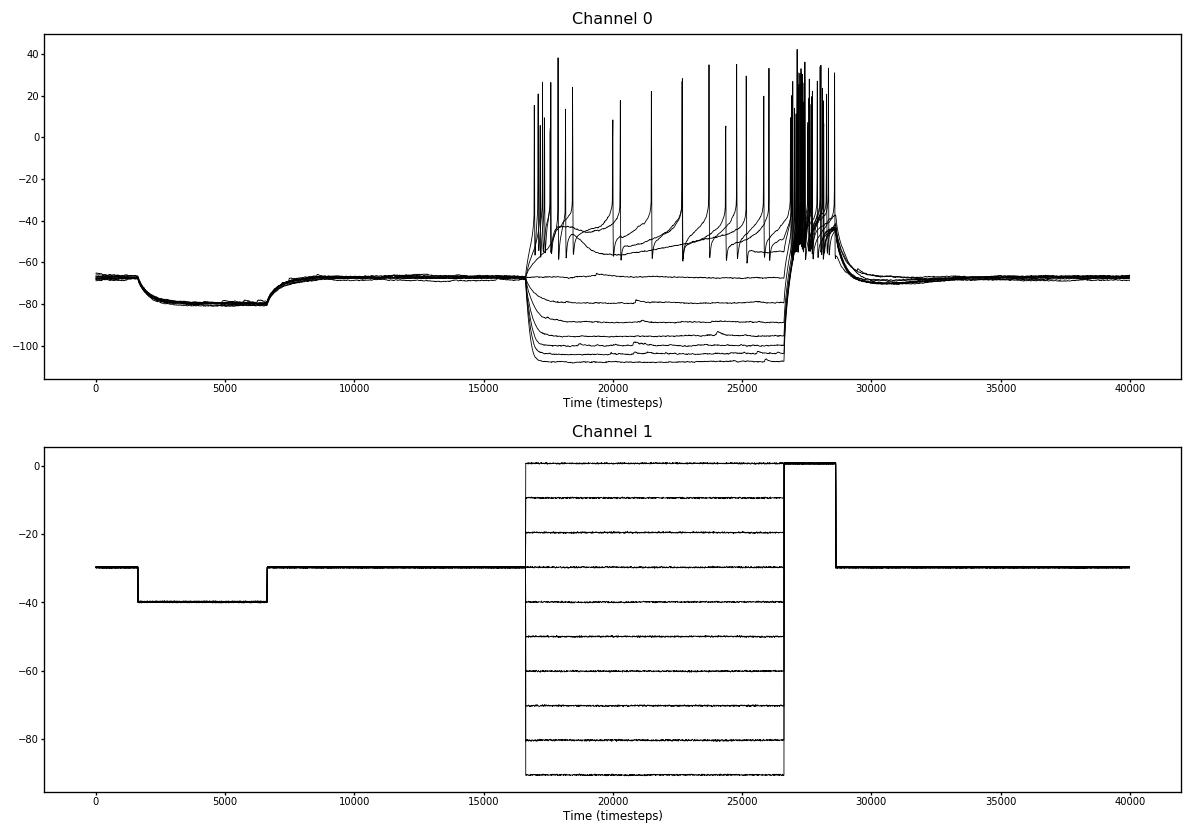

Recording 2


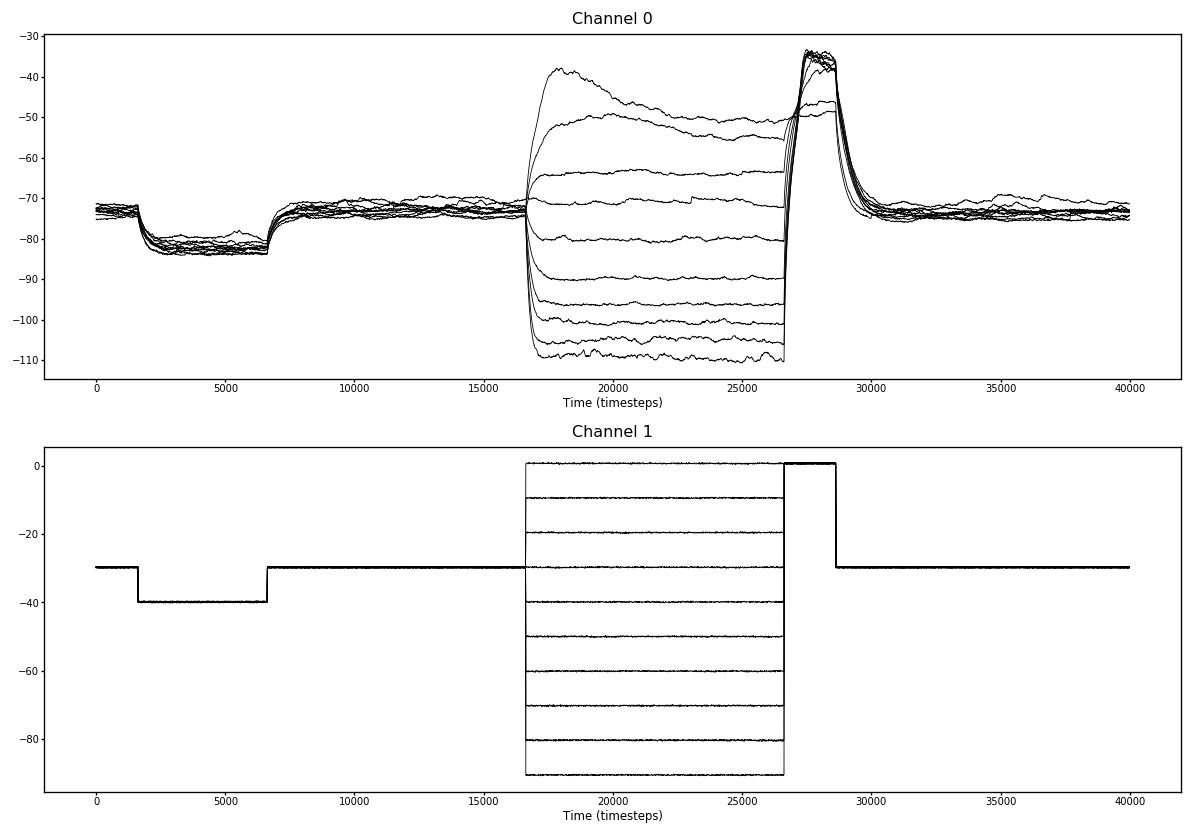

Recording 3


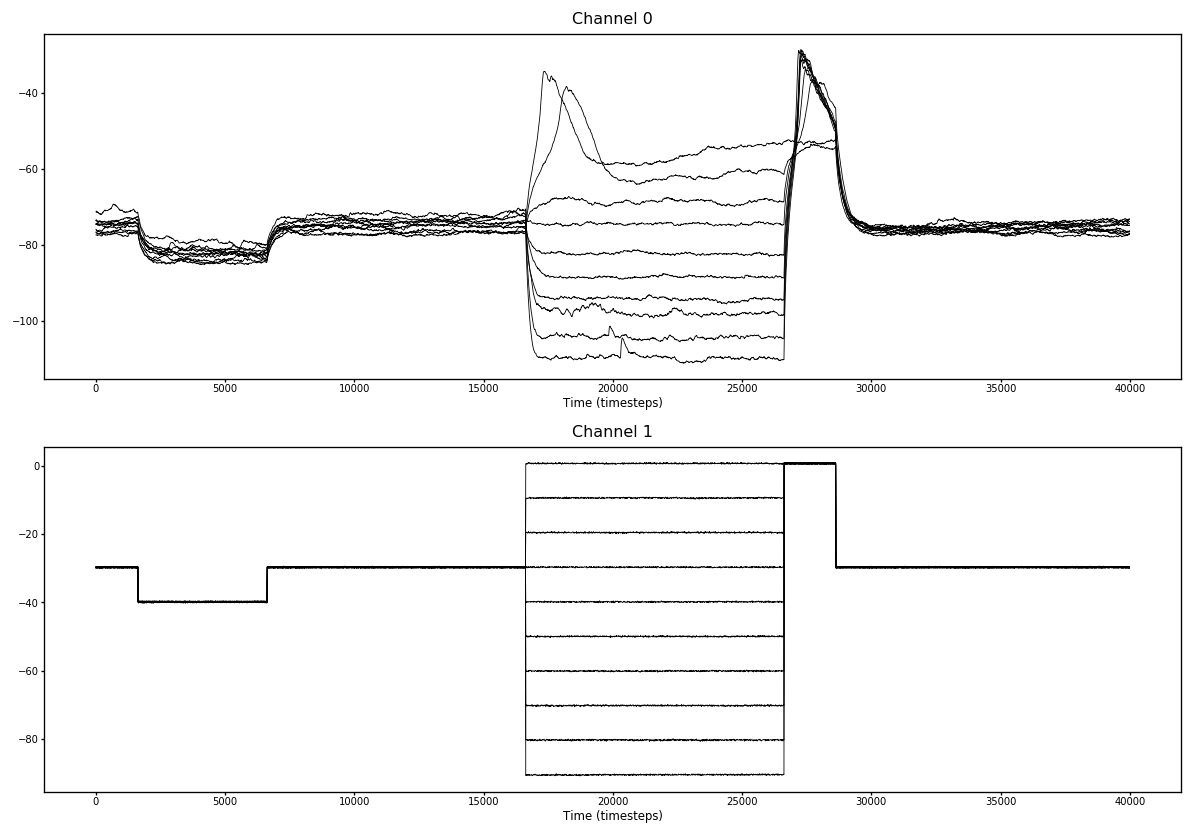

Recording 4


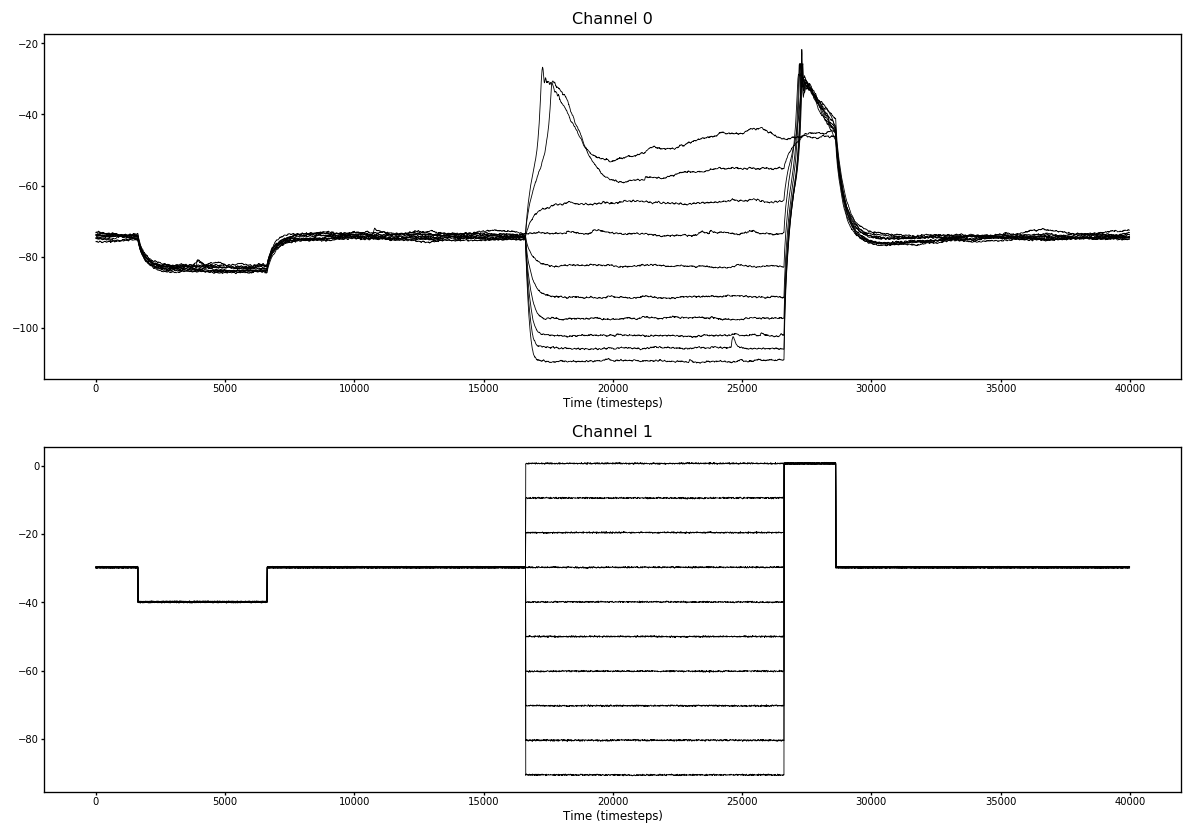

Recording 5


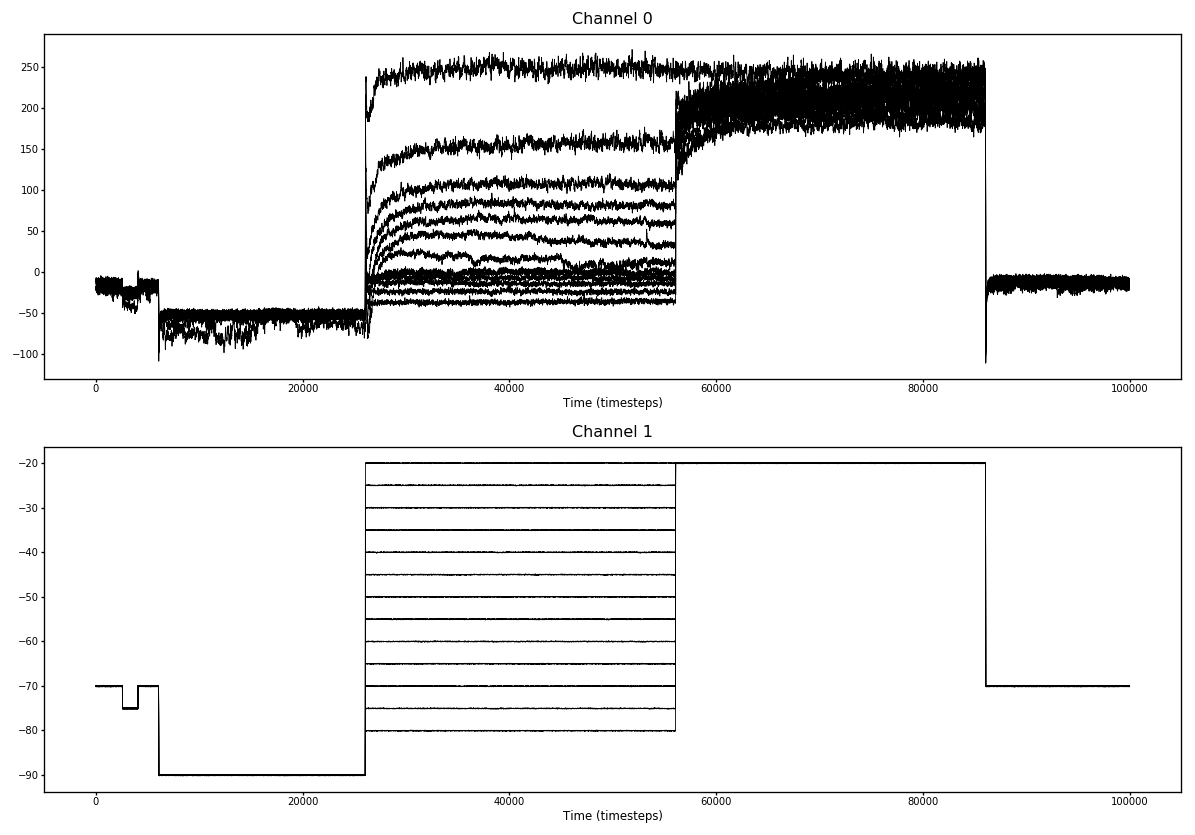

In [14]:
for i, rec in enumerate(bursty_recs):
    print('Recording {}'.format(i))
    rec.plot()

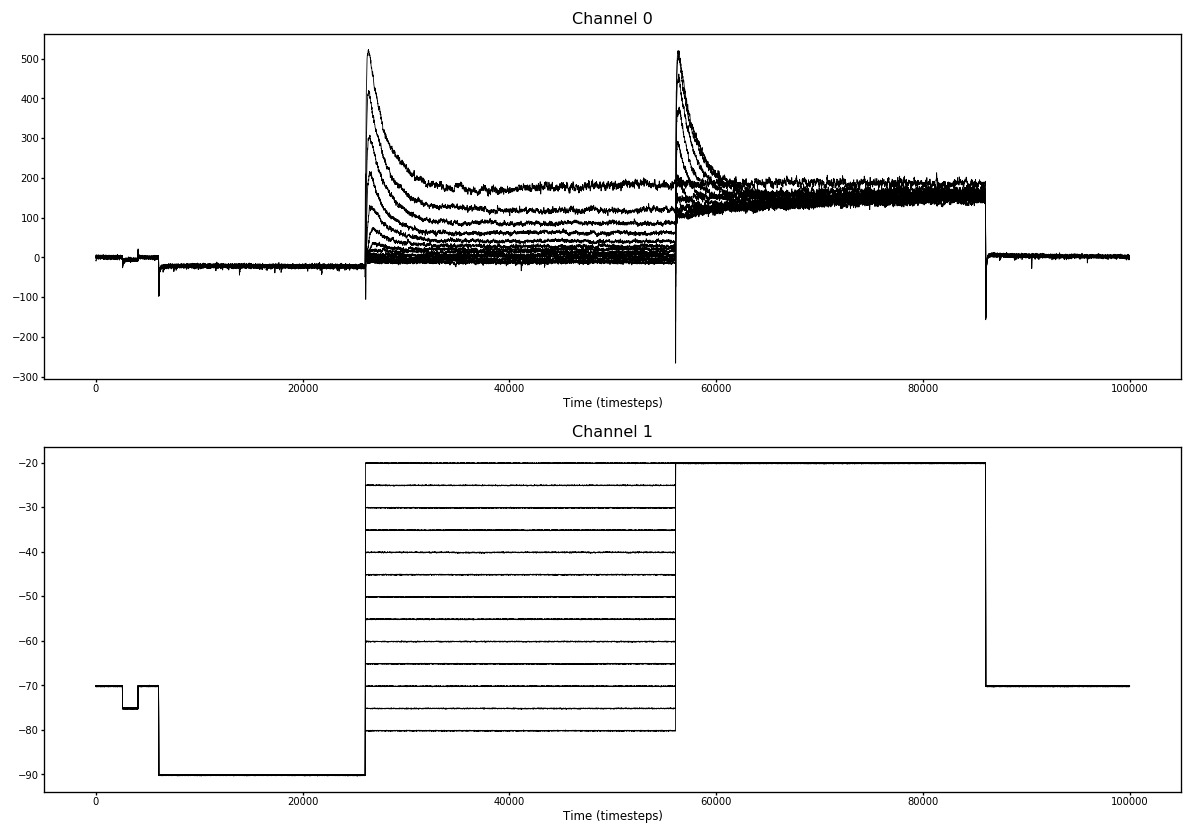

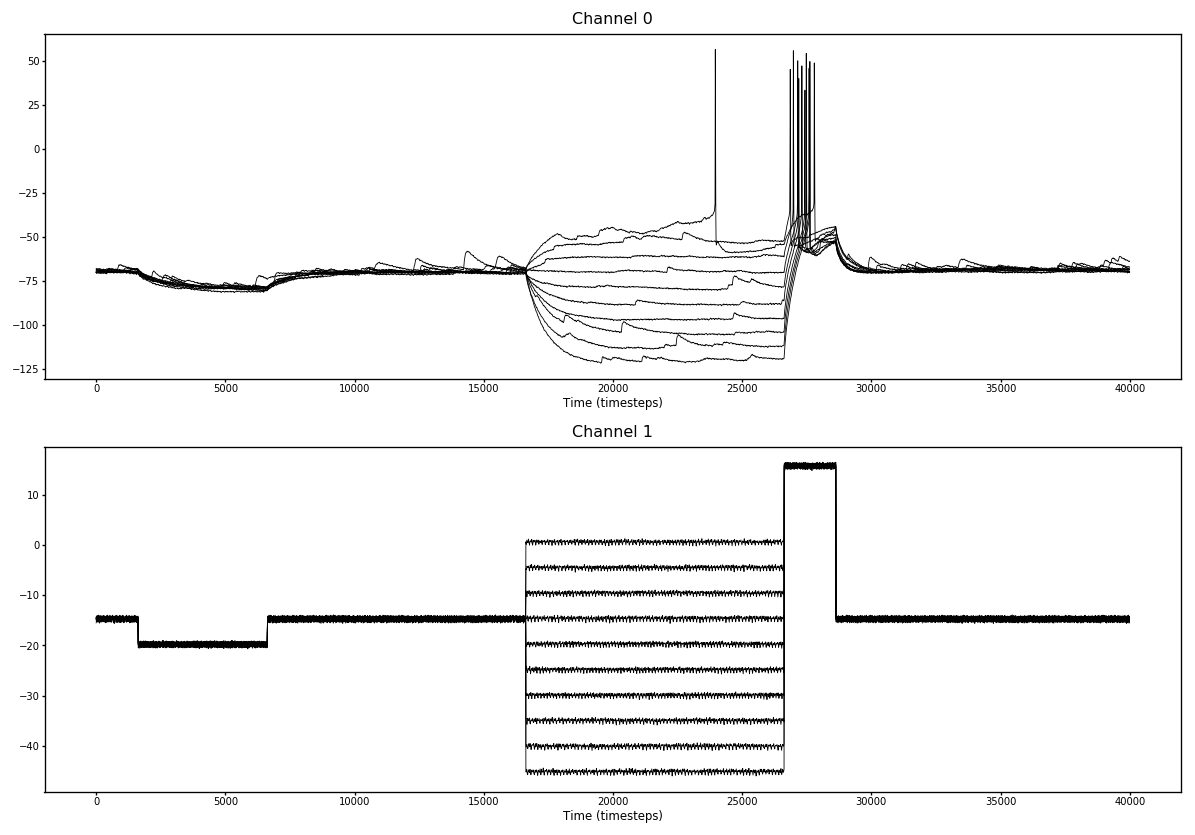

In [15]:
for rec in non_bursty_recs:
    rec.plot()

## Latency curve of bursty SOM.

In [16]:
bursty_latency = {'latency': [], 'voltage': []}
bursty_latency['current'] = (
    np.mean(bursty_recs[1][1, latency_extraction_params['I_step_slice'], :], axis=0)
    - np.mean(bursty_recs[1][1, latency_extraction_params['baseline_slice'], :])
)
for sweep in range(bursty_recs[1].shape[2]):
    bursty_latency['latency'].append(getSpikeLatency(
        bursty_recs[1][0, :, sweep],
        latency_extraction_params['step_start_time'],
    ))
    bursty_latency['voltage'].append(
        np.mean(
            bursty_recs[1][0, latency_extraction_params['V_pre_slice'], sweep]
        )
    )
    
for key in bursty_latency:
    bursty_latency[key] = np.array(bursty_latency[key])

In [17]:
bursty_latency

{'current': array([16.19643555, 17.7776123 , 19.33736572, 20.94881592, 22.50698242,
        24.09993896, 25.69161377, 27.26345215, 28.85067139, 30.42952881]),
 'latency': array([68.4, 68.1, 66.6, 65.7, 61.2, 55.2, 48.9,  nan,  nan,  nan]),
 'voltage': array([-107.54443359, -103.5461731 ,  -99.98748779,  -95.31594849,
         -88.67105103,  -79.18484497,  -67.51071167,  -50.95367432,
         -46.32635498,  -43.15374756])}

(0, 69.37500000000009)

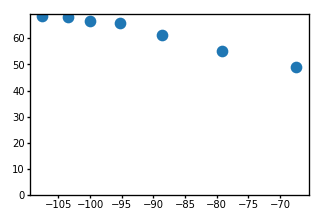

In [18]:
plt.plot(bursty_latency['voltage'], bursty_latency['latency'], 'o')
plt.ylim(0, plt.ylim()[1])

## Sample traces

In [19]:
bursty_vclamp_trace = bursty_recs[5]
bursty_iclamp_trace = bursty_recs[1]

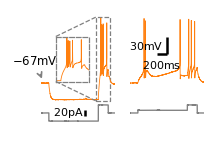

In [20]:
iclamp_spec = gs.GridSpec(2, 2, height_ratios=[1, 0.2], hspace=0)

plt.figure(figsize=(1.7, 1))

V_ax_lo = plt.subplot(iclamp_spec[0, 0])
plt.plot(bursty_iclamp_trace.time_supp, bursty_iclamp_trace[0, :, 3], color=colors['som'], lw=0.5)
V_ax_lo.set_xlim(1500, 3000)
V_baseline = bursty_iclamp_trace[0, 15000:15100, 3].mean()
V_ax_lo.annotate(
    '${:.0f}$mV'.format(V_baseline), 
    (1550, V_baseline + 2), 
    xytext=(-5, 10), 
    textcoords='offset points', 
    ha='center', 
    fontsize=7,
    arrowprops={'arrowstyle': '->'}
)
pltools.hide_ticks()
pltools.hide_border()


V_ax_lo_ins = inset_axes(V_ax_lo, '45%', '50%', 'center left', borderpad=1.5)
plt.plot(bursty_iclamp_trace.time_supp, bursty_iclamp_trace[0, :, 3], color=colors['som'], lw=0.5)
V_ax_lo_ins.set_xlim(2620, 2900)
V_ax_lo_ins.set_ylim(V_ax_lo.get_ylim()[0] + 5, V_ax_lo.get_ylim()[1] - 5)
pltools.hide_ticks(ax=V_ax_lo_ins)
dashedBorder(V_ax_lo_ins, lw=insetlw)
mark_inset(V_ax_lo, V_ax_lo_ins, 2, 3, color='gray', ls='--', lw=insetlw)

I_ax_lo = plt.subplot(iclamp_spec[1, 0])
plt.plot(bursty_iclamp_trace.time_supp, bursty_iclamp_trace[1, :, 3], color=colors['input'])
I_ax_lo.set_xlim(V_ax_lo.get_xlim())
pltools.add_scalebar(y_units='pA', y_size=20, omit_x=True, anchor=(0.6, 0.3), ax=I_ax_lo, linewidth=sbarlw)

V_ax_hi = plt.subplot(iclamp_spec[0, 1])
plt.plot(bursty_iclamp_trace.time_supp, bursty_iclamp_trace[0, :, 7], color=colors['som'], lw=0.5)
V_ax_hi.set_ylim(V_ax_lo.get_ylim())
V_ax_hi.set_xlim(V_ax_lo.get_xlim())
pltools.add_scalebar(
    'ms', 
    'mV', 
    y_size=30, 
    x_size=200, 
    anchor=(0.5, 0.55), 
    y_label_space=0.05, 
    x_label_space=-0.05, 
    bar_space=0, 
    ax=V_ax_hi,
    linewidth=sbarlw
)
plt.xticks([1600, 1800])

I_ax_hi = plt.subplot(iclamp_spec[1, 1])
plt.plot(bursty_iclamp_trace.time_supp, bursty_iclamp_trace[1, :, 7], color=colors['input'])
I_ax_hi.set_ylim(I_ax_lo.get_ylim())
I_ax_hi.set_xlim(V_ax_lo.get_xlim())
pltools.hide_ticks()
pltools.hide_border()

plt.subplots_adjust(left=0.15, bottom=0.05, right=0.95, top=0.95)


if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'gaba_bursty_current_clamp.png'))
    plt.savefig(os.path.join(IMG_PATH, 'gaba_bursty_current_clamp.svg'))

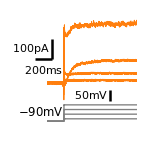

In [21]:
vclamp_spec = gs.GridSpec(2, 1, height_ratios=[1, 0.2], hspace=0)

plt.figure(figsize=(1, 1))

I_ax = plt.subplot(vclamp_spec[0, :])
I_ax.plot(bursty_vclamp_trace.time_supp, bursty_vclamp_trace[0, :, ::4], color=colors['som'], lw=0.5)
I_ax.set_xlim(2400, 3500)
pltools.add_scalebar(
    x_units='ms', 
    y_units='pA', 
    x_size=200, 
    y_size=100, 
    anchor=(0.05, 0.5), 
    x_label_space=-0.05, 
    bar_space=0,
    linewidth=sbarlw
)

V_ax = plt.subplot(vclamp_spec[1, :])
V_ax.plot(bursty_vclamp_trace.time_supp, bursty_vclamp_trace[1, :, ::4], color=colors['input'])
V_ax.set_xlim(I_ax.get_xlim())
initial_voltage = bursty_vclamp_trace[1, 22000:22100, :].mean()
V_ax.annotate(
    '${:.0f}$mV'.format(initial_voltage), 
    (V_ax.get_xlim()[0] + 200, initial_voltage + 20), 
    ha='right', 
    fontsize=7
)
pltools.add_scalebar(y_units='mV', y_size=50, anchor=(0.7, 1.1), omit_x=True, linewidth=sbarlw)

plt.subplots_adjust(left=0.20, bottom=0.05, right=0.95, top=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'gaba_bursty_voltage_clamp.png'))
    plt.savefig(os.path.join(IMG_PATH, 'gaba_bursty_voltage_clamp.svg'))

In [22]:
non_bursty_vclamp_trace = non_bursty_recs[0]
non_bursty_iclamp_trace = non_bursty_recs[1]

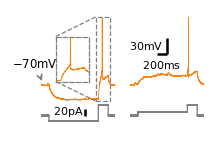

In [23]:
iclamp_spec = gs.GridSpec(2, 2, height_ratios=[1, 0.2], hspace=0)

plt.figure(figsize=(1.7, 1))

V_ax_lo = plt.subplot(iclamp_spec[0, 0])
plt.plot(non_bursty_iclamp_trace.time_supp, non_bursty_iclamp_trace[0, :, 3], color=colors['som'], lw=0.5)
V_ax_lo.set_xlim(1500, 3000)
V_baseline = non_bursty_iclamp_trace[0, 15000:15100, 3].mean()
V_ax_lo.annotate(
    '${:.0f}$mV'.format(V_baseline), 
    (1550, V_baseline + 2), 
    xytext=(-5, 10), 
    textcoords='offset points', 
    ha='center', 
    fontsize=7,
    arrowprops={'arrowstyle': '->'}
)
pltools.hide_ticks()
pltools.hide_border()


V_ax_lo_ins = inset_axes(V_ax_lo, '45%', '50%', 'center left', borderpad=1.5)
plt.plot(non_bursty_iclamp_trace.time_supp, non_bursty_iclamp_trace[0, :, 3], color=colors['som'], lw=0.5)
V_ax_lo_ins.set_xlim(2620, 2900)
V_ax_lo_ins.set_ylim(V_ax_lo.get_ylim()[0] + 5, V_ax_lo.get_ylim()[1] - 5)
pltools.hide_ticks(ax=V_ax_lo_ins)
dashedBorder(V_ax_lo_ins, lw=insetlw)
mark_inset(V_ax_lo, V_ax_lo_ins, 2, 3, color='gray', ls='--', lw=insetlw)

I_ax_lo = plt.subplot(iclamp_spec[1, 0])
plt.plot(non_bursty_iclamp_trace.time_supp, non_bursty_iclamp_trace[1, :, 3], color=colors['input'])
I_ax_lo.set_xlim(V_ax_lo.get_xlim())
pltools.add_scalebar(y_units='pA', y_size=20, omit_x=True, anchor=(0.6, 0.3), ax=I_ax_lo, linewidth=sbarlw)

V_ax_hi = plt.subplot(iclamp_spec[0, 1])
plt.plot(non_bursty_iclamp_trace.time_supp, non_bursty_iclamp_trace[0, :, 8], color=colors['som'], lw=0.5)
V_ax_hi.set_ylim(V_ax_lo.get_ylim())
V_ax_hi.set_xlim(V_ax_lo.get_xlim())
pltools.add_scalebar(
    'ms', 
    'mV', 
    y_size=30, 
    x_size=200, 
    anchor=(0.5, 0.55), 
    y_label_space=0.05, 
    x_label_space=-0.05, 
    bar_space=0, 
    ax=V_ax_hi,
    linewidth=sbarlw
)
plt.xticks([1600, 1800])

I_ax_hi = plt.subplot(iclamp_spec[1, 1])
plt.plot(non_bursty_iclamp_trace.time_supp, non_bursty_iclamp_trace[1, :, 8], color=colors['input'])
I_ax_hi.set_ylim(I_ax_lo.get_ylim())
I_ax_hi.set_xlim(V_ax_lo.get_xlim())
pltools.hide_ticks()
pltools.hide_border()

plt.subplots_adjust(left=0.15, bottom=0.05, right=0.95, top=0.95)


if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'gaba_nonbursty_current_clamp.png'))
    plt.savefig(os.path.join(IMG_PATH, 'gaba_nonbursty_current_clamp.svg'))

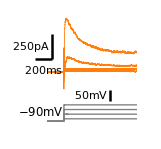

In [24]:
vclamp_spec = gs.GridSpec(2, 1, height_ratios=[1, 0.2], hspace=0)

plt.figure(figsize=(1, 1))

I_ax = plt.subplot(vclamp_spec[0, :])
I_ax.plot(non_bursty_vclamp_trace.time_supp, non_bursty_vclamp_trace[0, :, ::4], color=colors['som'], lw=0.5)
I_ax.set_xlim(2400, 3500)
pltools.add_scalebar(
    x_units='ms', 
    y_units='pA', 
    x_size=200, 
    y_size=250, 
    anchor=(0.05, 0.5), 
    x_label_space=-0.05, 
    bar_space=0,
    linewidth=sbarlw
)

V_ax = plt.subplot(vclamp_spec[1, :])
V_ax.plot(non_bursty_vclamp_trace.time_supp, non_bursty_vclamp_trace[1, :, ::4], color=colors['input'])
V_ax.set_xlim(I_ax.get_xlim())
initial_voltage = non_bursty_vclamp_trace[1, 22000:22100, :].mean()
V_ax.annotate(
    '${:.0f}$mV'.format(initial_voltage), 
    (V_ax.get_xlim()[0] + 200, initial_voltage + 20), 
    ha='right', 
    fontsize=7
)
pltools.add_scalebar(y_units='mV', y_size=50, anchor=(0.7, 1.1), omit_x=True, linewidth=sbarlw)

plt.subplots_adjust(left=0.20, bottom=0.05, right=0.95, top=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'gaba_nonbursty_voltage_clamp.png'))
    plt.savefig(os.path.join(IMG_PATH, 'gaba_nonbursty_voltage_clamp.svg'))